# Laboratorio 4

#### Sebastian Aristondo 20880
#### Daniel Gonzalez 20293

In [345]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import opinion_lexicon
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('opinion_lexicon')
nltk.download('vader_lexicon')
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.sentiment import SentimentIntensityAnalyzer

positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())
negative_words.add("earthquake")
negative_words.add("fire")
negative_words.add("evacuation")
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 1. Limpieza y preprocesamiento

El dataset tiene los datos crudos, por lo que debemos de limpiarlos y preprocesarlos para poder trabajar con ellos. Para esto, se utilizo la libreria pandas para poder leer el archivo csv y poder trabajar con el. Luego utilizaremos varias funciones de nltk para poder limpiar los datos y dejarlos listos para poder trabajar con ellos.

In [346]:
data = pd.read_csv('train.csv')

In [347]:
def remove_urls(text):
    url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return re.sub(url_pattern, '', text)

In [348]:
data['text'] = data['text'].apply(remove_urls)

In [349]:
data['text'] = data['text'].str.replace('[^a-zA-Z]', ' ', regex=True)
data['text'] = data['text'].apply(lambda x: x.lower())

Se realizaron tres acciones iniciales para limpiar y preprocesar datos. Primero se eliminó cualquier URL de los datos usando una expresión regular. También se mantuvieron solamente los caracteres que estuvieran de la a a la z, mayúsculas o minúsculas. Esto quiere decir que se quitó cualquier caracter como "#" o "@" y signos de puntuación. Por otra parte, se pasaron todas las palabras a minúsculas.

In [350]:
def remove_stop_words(sentence):
    stop_words = set(stopwords.words('english'))  
    words = sentence.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    new_sentence = ' '.join(filtered_words)
    return new_sentence

data['text_clean'] = data['text'].apply(remove_stop_words)


Para que nuestro modelo tenga un mejor desempeño, quitaremos las palabras que no aportan información al modelo. Estas palabras se conocen como "stopwords". Para esto, usaremos la librería nltk. Esta librería tiene una lista de stopwords en inglés que usaremos para quitar las palabras que no aportan información.

In [351]:
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

data['text_lemmatized'] = data['text_clean'].apply(lambda x: lemmatize_words(x.split()))

El modelo no puede diferenciar entre correr, corriendo, correrá, etc. Para esto, usaremos un proceso llamado lemmatization. Este proceso consiste en convertir las palabras a su forma base. Por ejemplo, correr, corriendo, correrá, etc. se convertirán a correr. Esto nos ayudará a que el modelo pueda diferenciar entre palabras que tienen el mismo significado pero que están escritas de manera diferente.

## 2. Análisis exploratorio

In [352]:
data.head()

,id,keyword,location,text,target,text_clean,text_lemmatized
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1,deeds reason earthquake may allah forgive us,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,all residents asked to shelter in place are ...,1,residents asked shelter place notified officer...,"[resident, asked, shelter, place, notified, of..."
3,6,NaN,NaN,people receive wildfires evacuation or...,1,people receive wildfires evacuation orders cal...,"[people, receive, wildfire, evacuation, order,..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


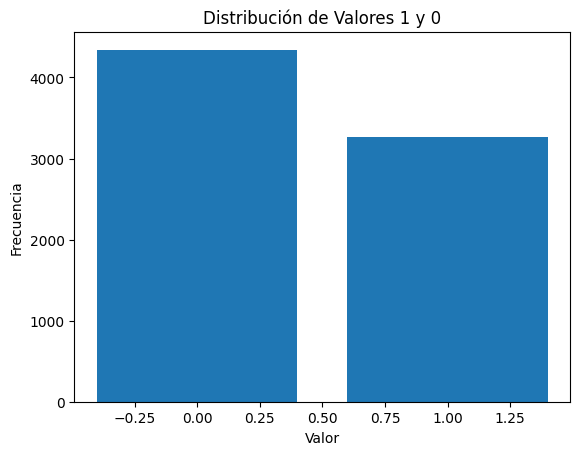

In [353]:
# Calcular la frecuencia de valores
value_counts = data['target'].value_counts()

# Crear el gráfico de barras
plt.bar(value_counts.index, value_counts.values)

# Etiquetas y título
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Distribución de Valores 1 y 0')

# Mostrar el gráfico
plt.show()

Se puede observar que la cantidad de tweets de desastres y los que no son está relativamente balanceada. Hay una mayor cantidad de tweets que no son de desastres, pero no es una diferencia muy grande.

In [354]:
palabras_comunes = {0: None, 1: None}

# Iterar a través de las etiquetas únicas
for etiqueta in data['target'].unique():
    # Filtrar el DataFrame por la etiqueta actual
    df_filtrado = data[data['target'] == etiqueta]
    
    # Unir todas las listas de palabras en una sola lista
    todas_las_palabras = [palabra for lista_palabras in df_filtrado['text_lemmatized'] for palabra in lista_palabras]
    
    # Contar la frecuencia de cada palabra
    contador = Counter(todas_las_palabras)
    
    # Obtener la palabra más común
    palabra_mas_comun = contador.most_common(1)[0][0]
    
    # Almacenar la palabra más común en el diccionario
    palabras_comunes[etiqueta] = palabra_mas_comun

# Imprimir las palabras más comunes por etiqueta
print("Palabra más común para etiqueta 0:", palabras_comunes[0])
print("Palabra más común para etiqueta 1:", palabras_comunes[1])


Palabra más común para etiqueta 0: like
Palabra más común para etiqueta 1: fire


Como podemos ver el dataset en la etiqueta 1 (si es un desastre) la palabra que más se repite es fire, mientas que los tweets que no son desastres la palabra que más se repite es like. Esto nos da una idea de que palabras son las que más se repiten en cada etiqueta. Es importante destacar que esto no sería posible si no se hubiesen quitado las stopwords y si no se hubiese hecho lemmatization.

Wordcloud para Etiqueta 0:


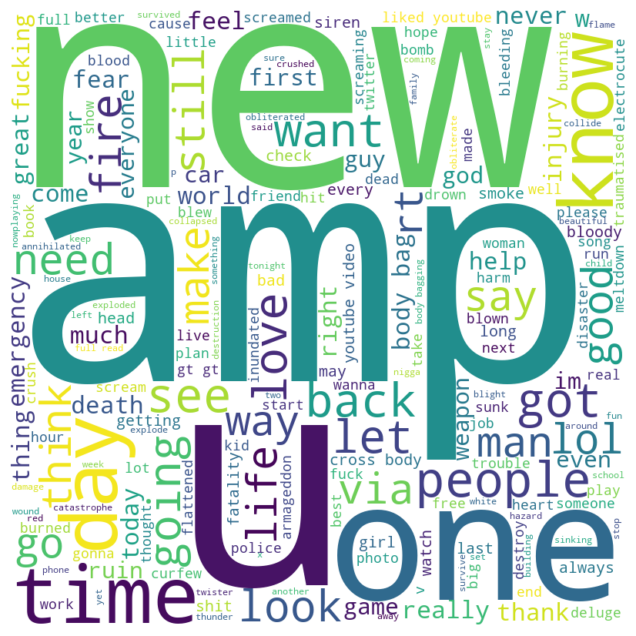

Wordcloud para Etiqueta 1:


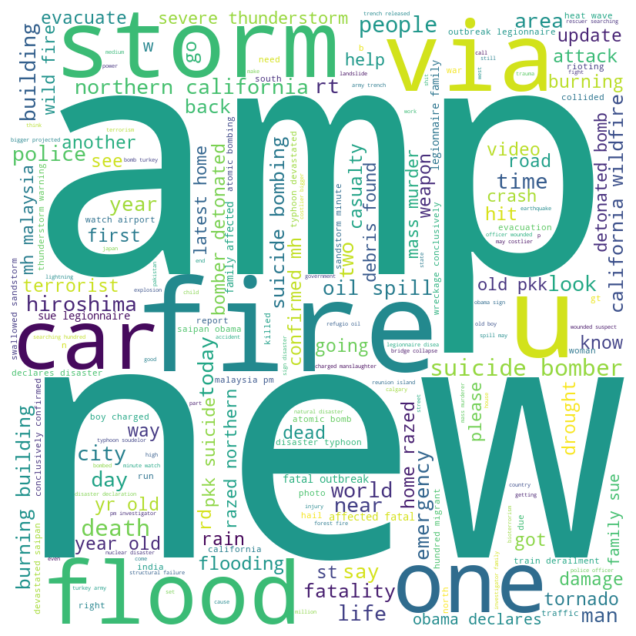

In [355]:
def process_text(text_list):
    return ' '.join(text_list)

data_clouds = data.copy()
data_clouds['processed_text'] = data_clouds['text_lemmatized'].apply(process_text)

# Separar los datos según la etiqueta
data_label_0 = data_clouds[data_clouds['target'] == 0]
data_label_1 = data_clouds[data_clouds['target'] == 1]

# Paso 2: Creación de Wordclouds
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

text_label_0 = ' '.join(data_label_0['processed_text'])
text_label_1 = ' '.join(data_label_1['processed_text'])

# Generar wordclouds para cada etiqueta
print("Wordcloud para Etiqueta 0:")
generate_wordcloud(text_label_0)

print("Wordcloud para Etiqueta 1:")
generate_wordcloud(text_label_1)

De las nubes de palabras se puede observar que la nube de palabras de desastres tiene varias palabras asociadas a ellos. Por ejemplo "emergency" o "police" o "fire" tienen bastante incidencia. Por otra parte, la nube de palabras de los tweets que no son de desastres tienen palabras como "like" o "get" o "one", palabras que no tienen mucha relación con desastres.

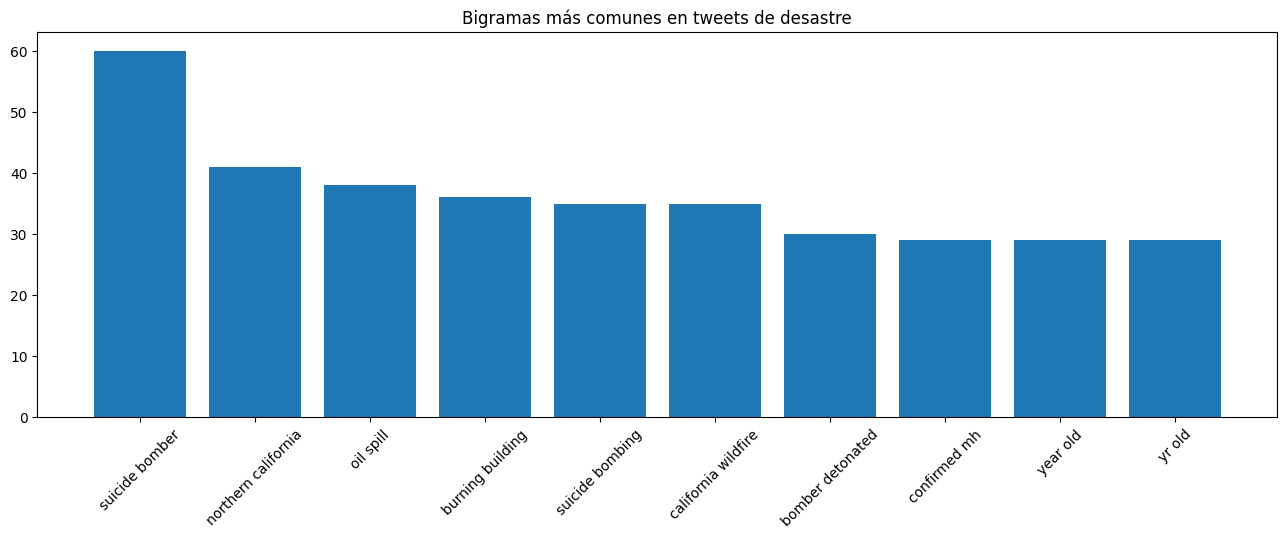

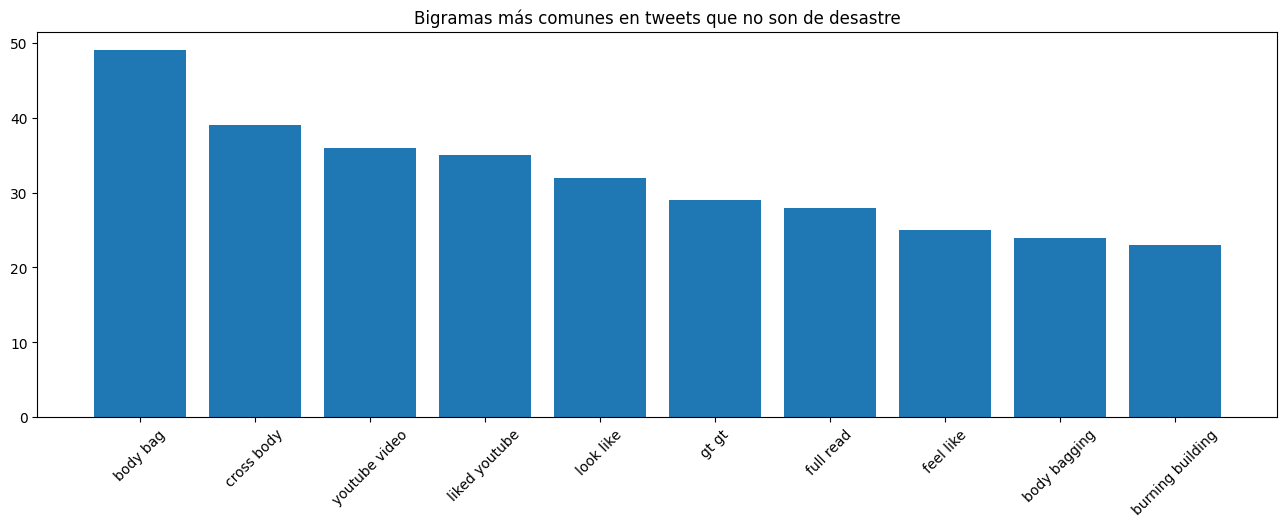

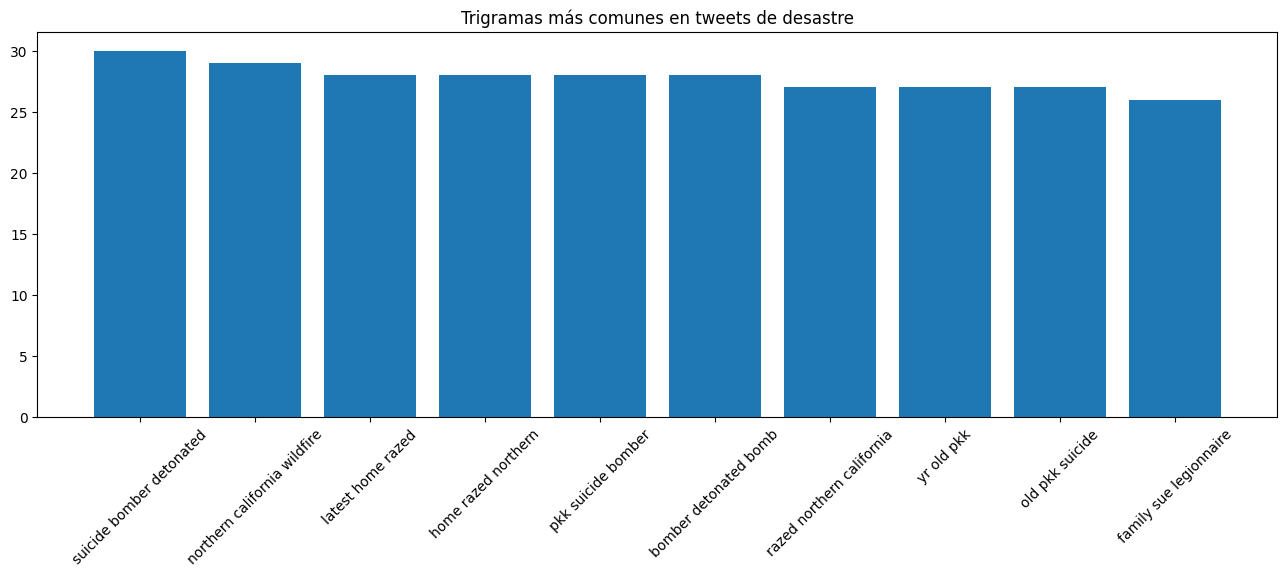

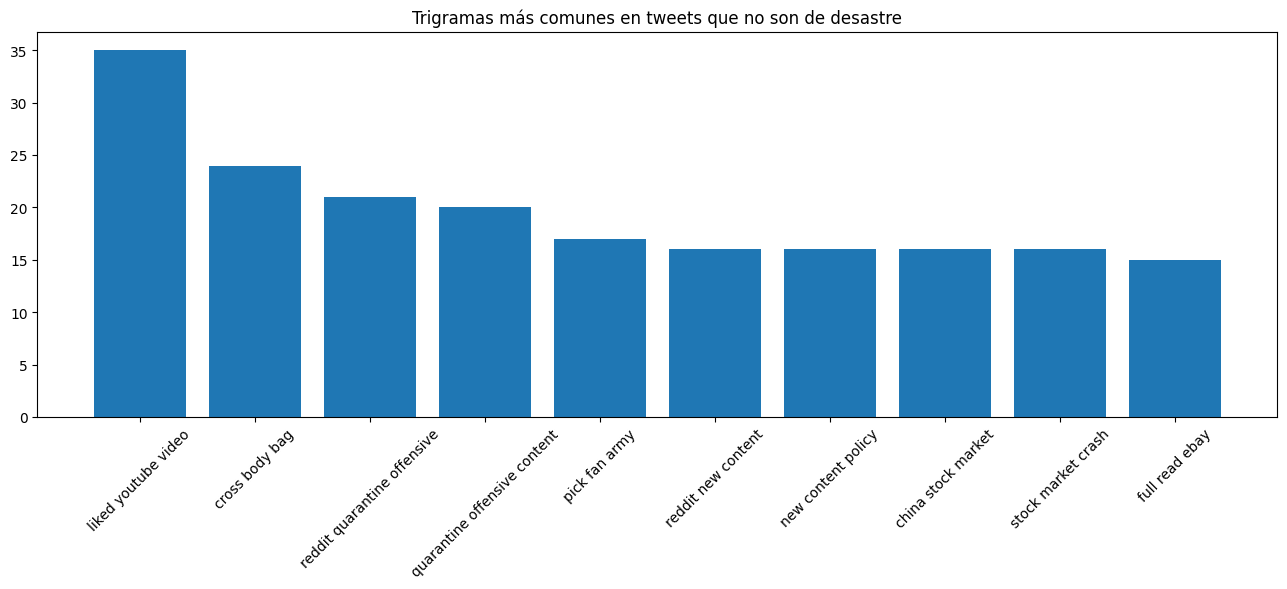

In [356]:
from nltk.util import bigrams, trigrams
from nltk.probability import FreqDist
disaster_tokens = [word for word_list in data[data['target'] == 1]['text_lemmatized'] for word in word_list]
non_disaster_tokens = [word for word_list in data[data['target'] == 0]['text_lemmatized'] for word in word_list]



disaster_bigrams = list(bigrams(disaster_tokens))
disaster_trigrams = list(trigrams(disaster_tokens))

non_disaster_bigrams = list(bigrams(non_disaster_tokens))
non_disaster_trigrams = list(trigrams(non_disaster_tokens))

disaster_bigram_freq = FreqDist(disaster_bigrams)
non_disaster_bigram_freq = FreqDist(non_disaster_bigrams)

disaster_trigram_freq = FreqDist(disaster_trigrams)
non_disaster_trigram_freq = FreqDist(non_disaster_trigrams)


def plot_most_common_bigrams(freq_dist, title):
    bigrams, frequencies = zip(*freq_dist.most_common(10))
    bigrams_str = [' '.join(bigram) for bigram in bigrams]  # Convertir bigramas a cadenas para la visualización
    plt.figure(figsize=(16, 5))
    plt.bar(bigrams_str, frequencies)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_most_common_bigrams(disaster_bigram_freq, 'Bigramas más comunes en tweets de desastre')
plot_most_common_bigrams(non_disaster_bigram_freq, 'Bigramas más comunes en tweets que no son de desastre')
plot_most_common_bigrams(disaster_trigram_freq, 'Trigramas más comunes en tweets de desastre')
plot_most_common_bigrams(non_disaster_trigram_freq, 'Trigramas más comunes en tweets que no son de desastre')

Como podemos ver en los bigramas o trigramas para los desastres lo más común habla respecto a incedios, bombardero suicida, gente de avanzada edad y derrame de aciete

Mientras que los que no son desastre hablan de gustos


### Clasificación de palabras por tweets

Nltk proporciona un conjunto de datasets que contienen palabras clasificadas por su uso. De esta forma podemos clasificar las palabras de los tweets en positivas,neutras y negativas. Luego haremos un análisis de sentimiento para ver si los tweets de desastres tienen un sentimiento más negativo que los que no son de desastres. Adionalmente separaremos las palabras e diferentes listas para luego poder dibujarlas en una nube de palabras.

In [357]:
Negativas = []
Positivas = []
Neutras = []

In [358]:
def classify_word_sentiment(sentence):
    negativas_cont = 0
    positivas_cont = 0
    neutras_cont = 0
    for word in sentence.split():
        sentiment_scores = sia.polarity_scores(word)
        if word in positive_words:
            if word not in Positivas or sentiment_scores['compound'] >= 0.05:
                Positivas.append(word)
            positivas_cont += 1
        elif word in negative_words or sentiment_scores['compound'] <= -0.05:
            if word not in Negativas:
                Negativas.append(word)
            negativas_cont += 1
        else:
            if word not in Neutras:
                Neutras.append(word)
            neutras_cont += 1
    return positivas_cont, negativas_cont, neutras_cont

Para determinar si una palabra es positiva o negativa, combinamos el uso de un diccionario proporcionado por NLTK y un índice de polaridad. A partir de esto, almacenamos las palabras en listas y calculamos la cantidad de palabras por cada categoría para cada tweet.

In [359]:
data['Lista'] = data['text_clean'].apply(classify_word_sentiment)

In [360]:
print("Palabras positivas:", len(Positivas))
print("Palabras negativas:", len(Negativas))
print("Palabras neutras:", len(Neutras))

Palabras positivas: 2241
Palabras negativas: 1260
Palabras neutras: 14342


Wordcloud para palabras positivas:


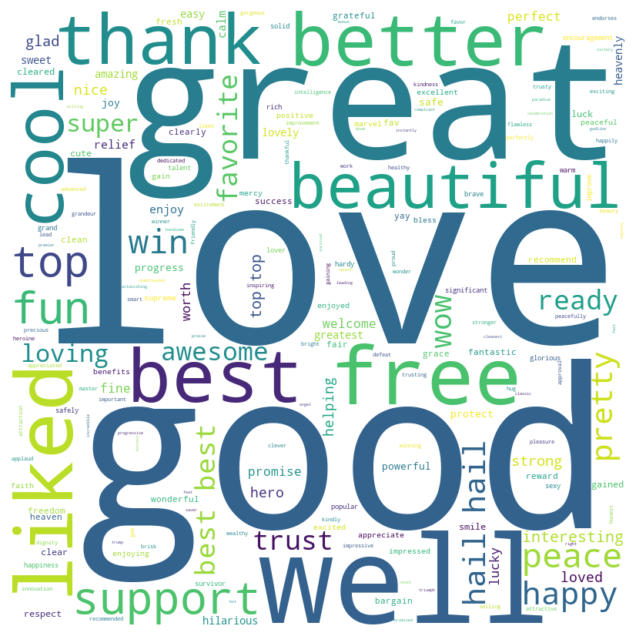

In [361]:
print("Wordcloud para palabras positivas:")
generate_wordcloud(' '.join(Positivas))

Decidimos que para visualizar las palabras positivas hariamos un wordcloud con todas las palabras positivas encontradas dentro de los tweets. Para esto, se utilizo la libreria nltk para poder encontrar las palabras positivas dentro de los tweets. Luego se utilizo la libreria wordcloud para poder visualizar las palabras positivas.

Wordcloud para palabras negativas:


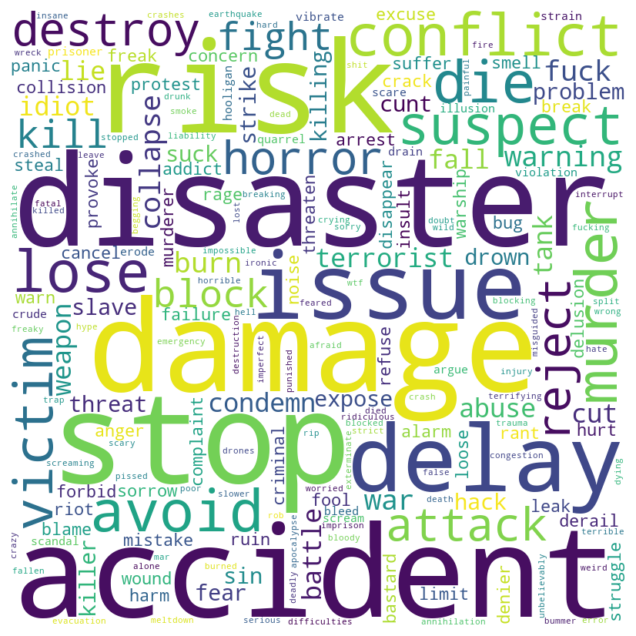

In [362]:
print("Wordcloud para palabras negativas:")
generate_wordcloud(' '.join(Negativas))

Decidimos que para visualizar las palabras negativas hariamos un wordcloud con todas las palabras negativas encontradas dentro de los tweets. Para esto, se utilizo la libreria nltk para poder encontrar las palabras negativas dentro de los tweets. Luego se utilizo la libreria wordcloud para poder visualizar las palabras negativas.

Wordcloud para palabras neutras:


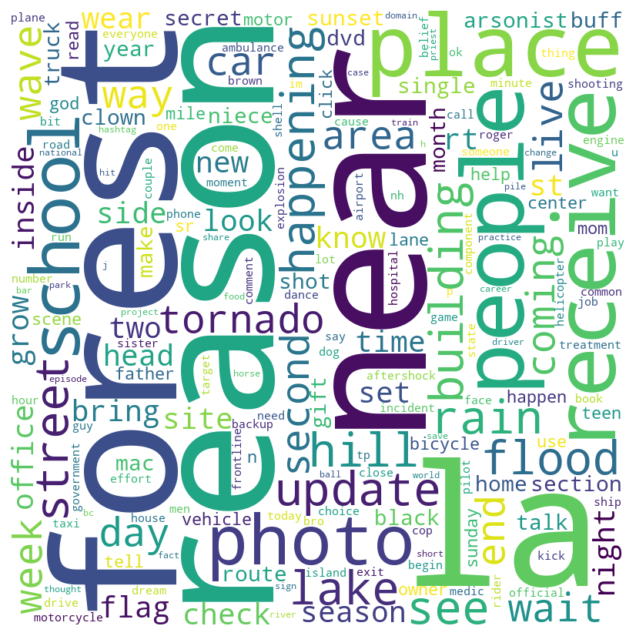

In [363]:
print("Wordcloud para palabras neutras:")
generate_wordcloud(' '.join(Neutras))

Decidimos que para visualizar las palabras neutras hariamos un wordcloud con todas las palabras neutras encontradas dentro de los tweets. Para esto, se utilizo la libreria nltk para poder encontrar las palabras neutras dentro de los tweets. Luego se utilizo la libreria wordcloud para poder visualizar las palabras neutras.

Cabe destacar que algunas palabras estaban mal ubicados, por lo que fueron movidas a su respectiva categoría. Este proceso forma parte del ananlisis exploratorio. Ya dado este contexto nosotros como investigadores debemos de tener el criterio para poder analizar los datos y poder determinar si estan bien o mal. En este caso, se movieron algunas palabras a su respectiva categoría.

In [364]:
def separar_tuplas(tupla):
    return pd.Series(tupla)

# Aplicar la función a la columna y crear nuevas columnas
data[['Cantidad_palabras_positivas', 'Cantidad_palabras_negativas', 'Cantidad_palabras_neutras']] = data['Lista'].apply(separar_tuplas)


### Clasificación de tweets en positivos, neutros y negativos

Ahora que ya tenemos la cantidad de palabras positivas,negativas y neutras en cada tweet calcularemos la polaridad de cada tweet. Para esto, utilizaremos la libreria Vader. Esta libreria nos permite calcular la polaridad de un texto. La polaridad va de -1 a 1, donde -1 es negativo, 0 es neutro y 1 es positivo. Luego de calcular la polaridad de cada tweet, los clasificaremos en positivos, neutros y negativos. Para esto, utilizaremos un umbral de 0.2. Si la polaridad es mayor a 0.2, el tweet será positivo. Si la polaridad es menor a -0.2, el tweet será negativo. Si la polaridad está entre -0.2 y 0.2, el tweet será neutro.

In [365]:
def calcular_indice(tupla):
    return (tupla[0] - tupla[1]) / (tupla[0] + tupla[1] + tupla[2])

data['negatividad_del_tweet'] = data['Lista'].apply(calcular_indice)

In [366]:
data_ordenada = data.sort_values(by=['negatividad_del_tweet'], ascending=True)

In [367]:
data_ordenada.head(10)

,id,keyword,location,text,target,text_clean,text_lemmatized,Lista,Cantidad_palabras_positivas,Cantidad_palabras_negativas,Cantidad_palabras_neutras,negatividad_del_tweet
90,132,accident,NaN,it was an accident,0,accident,[accident],"(0, 1, 0)",0,1,0,-1.0
481,691,attack,ph,anxiety attack,0,anxiety attack,"[anxiety, attack]","(0, 2, 0)",0,2,0,-1.0
5115,7295,nuclear%20reactor,NaN,err,0,err,[err],"(0, 1, 0)",0,1,0,-1.0
3717,5285,fear,"Thibodaux, LA",my worst fear,0,worst fear,"[worst, fear]","(0, 2, 0)",0,2,0,-1.0
7472,10689,wreck,NaN,wreck wreck wreck wreck wreck wreck wreck wre...,0,wreck wreck wreck wreck wreck wreck wreck wrec...,"[wreck, wreck, wreck, wreck, wreck, wreck, wre...","(0, 13, 0)",0,13,0,-1.0
7470,10687,wreck,NaN,i am a wreck,0,wreck,[wreck],"(0, 1, 0)",0,1,0,-1.0
6780,9714,tragedy,#SandraBland,don t forget tragedy,0,forget tragedy,"[forget, tragedy]","(0, 2, 0)",0,2,0,-1.0
4971,7088,meltdown,NaN,meltdown,0,meltdown,[meltdown],"(0, 1, 0)",0,1,0,-1.0
5988,8551,screams,blackfalds.,screams,0,screams,[scream],"(0, 1, 0)",0,1,0,-1.0
3696,5259,fatality,Honduras,fatality,0,fatality,[fatality],"(0, 1, 0)",0,1,0,-1.0


Se calculó el índice de polaridad para cada tweet, el cual se hizo restando la cantidad de palabras positivas de las negativas dividiendo entre el total de palabras del tweet. Se puede observar que los tweets más negaticos no pertenecen a la categoría de tweets que son una emergencia real.

In [368]:
data_ordenada = data.sort_values(by=['negatividad_del_tweet'], ascending=False)

In [369]:
data_ordenada.head(10)

,id,keyword,location,text,target,text_clean,text_lemmatized,Lista,Cantidad_palabras_positivas,Cantidad_palabras_negativas,Cantidad_palabras_neutras,negatividad_del_tweet
6140,8759,siren,Team Slytherin,super sweet and beautiful,0,super sweet beautiful,"[super, sweet, beautiful]","(3, 0, 0)",3,0,0,1.0
27,39,NaN,NaN,love my girlfriend,0,love girlfriend,"[love, girlfriend]","(1, 0, 1)",1,0,1,0.5
22,33,NaN,NaN,love skiing,0,love skiing,"[love, skiing]","(1, 0, 1)",1,0,1,0.5
21,32,NaN,NaN,london is cool,0,london cool,"[london, cool]","(1, 0, 1)",1,0,1,0.5
29,41,NaN,NaN,do you like pasta,0,like pasta,"[like, pasta]","(1, 0, 1)",1,0,1,0.5
4092,5817,hail,Between Dire and Radiant,hail pic,0,hail pic,"[hail, pic]","(1, 0, 1)",1,0,1,0.5
18,26,NaN,NaN,my car is so fast,0,car fast,"[car, fast]","(1, 0, 1)",1,0,1,0.5
17,25,NaN,NaN,summer is lovely,0,summer lovely,"[summer, lovely]","(1, 0, 1)",1,0,1,0.5
16,24,NaN,NaN,i love fruits,0,love fruits,"[love, fruit]","(1, 0, 1)",1,0,1,0.5
4126,5867,hailstorm,NaN,my favorite text,0,favorite text,"[favorite, text]","(1, 0, 1)",1,0,1,0.5


Se puede observar que igualmente, los 10 tweets más positivos no pertenecen a la categoría de tweets que son una emergencia real.

In [370]:
filas_con_uno = data[data['target'] == 1]['negatividad_del_tweet']

# Calcular el promedio de las filas filtradas
promedio = filas_con_uno.mean()
print("\nPromedio de polaridad de los accidentes reales:")
print(str(promedio))


Promedio de polaridad de los accidentes reales:
-0.13235885325984972


In [371]:
filas_con_uno = data[data['target'] == 0]['negatividad_del_tweet']

# Calcular el promedio de las filas filtradas
promedio = filas_con_uno.mean()
print("\nPromedio de polaridad de no accidentes:")
print(str(promedio))


Promedio de polaridad de no accidentes:
-0.08997894800385191


Se puede observar que los tweets que son una emergencia real tienen una polaridad más negativa que los que no son accidentes. Sin embargo, la polaridad es relativamente baja. La polaridad de los accidentes que no son reales, es bastante baja y se puede catalogar como neutra.

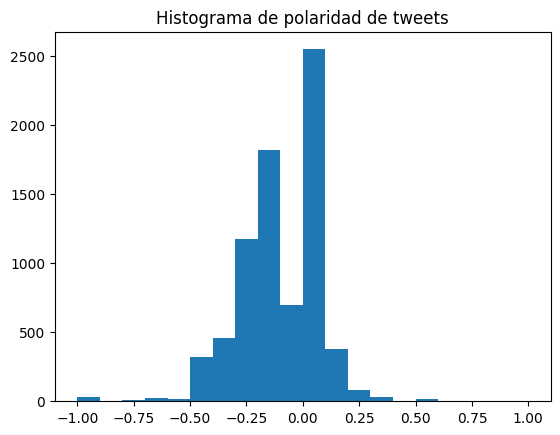

In [372]:
plt.hist(data['negatividad_del_tweet'], bins=20)
plt.title("Histograma de polaridad de tweets")
plt.show()

### Modelo

In [373]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


# Cargar tu conjunto de datos en un DataFrame (df)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data[['text_clean', 'negatividad_del_tweet']], data['target'], test_size=0.2, random_state=42)

# Vectorizar el texto usando CountVectorizer
vectorizer = CountVectorizer()
X_train_text = vectorizer.fit_transform(X_train['text_clean'])
X_test_text = vectorizer.transform(X_test['text_clean'])

scaler = MinMaxScaler()
X_train['negatividad_del_tweet'] = scaler.fit_transform(X_train['negatividad_del_tweet'].values.reshape(-1, 1))
X_test['negatividad_del_tweet'] = scaler.transform(X_test['negatividad_del_tweet'].values.reshape(-1, 1))

# Combinar la matriz vectorizada del texto con el índice de negatividad
import scipy.sparse
X_train_combined = scipy.sparse.hstack([X_train_text, X_train['negatividad_del_tweet'].values.reshape(-1, 1)])
X_test_combined = scipy.sparse.hstack([X_test_text, X_test['negatividad_del_tweet'].values.reshape(-1, 1)])

# Inicializar y entrenar el clasificador Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_combined, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = nb_classifier.predict(X_test_combined)

# Evaluar el rendimiento del clasificador
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)


Accuracy: 0.788575180564675
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       874
           1       0.77      0.72      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



Como podemos ver el modelo empeoro al utilizar la polaridad de los tweets. Esto se debe a que la polaridad de los tweets no significa que el tweet sea un desastre o no. Por ejemplo, un tweet puede ser positivo pero puede ser un desastre. Por otra parte, un tweet puede ser negativo pero no ser un desastre. Por lo tanto, la polaridad no es un buen indicador para saber si un tweet es un desastre o no. A pesar de unicamente se perdión un 2% de accuracy, en comparación con el modelo anterior.